In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cancer1/data/val/ISIC_0004715.png
/kaggle/input/cancer1/data/val/ISIC_0009883.png
/kaggle/input/cancer1/data/val/ISIC_0011088.png
/kaggle/input/cancer1/data/val/ISIC_0010204.png
/kaggle/input/cancer1/data/val/ISIC_0002489.png
/kaggle/input/cancer1/data/val/ISIC_0000345.png
/kaggle/input/cancer1/data/val/ISIC_0010480.png
/kaggle/input/cancer1/data/val/ISIC_0000363.png
/kaggle/input/cancer1/data/val/ISIC_0000546.png
/kaggle/input/cancer1/data/val/ISIC_0000007.png
/kaggle/input/cancer1/data/val/ISIC_0000408.png
/kaggle/input/cancer1/data/val/ISIC_0011123.png
/kaggle/input/cancer1/data/val/ISIC_0006350.png
/kaggle/input/cancer1/data/val/ISIC_0000093.png
/kaggle/input/cancer1/data/val/ISIC_0010566.png
/kaggle/input/cancer1/data/val/ISIC_0009979.png
/kaggle/input/cancer1/data/val/ISIC_0000444.png
/kaggle/input/cancer1/data/val/ISIC_0009974.png
/kaggle/input/cancer1/data/val/ISIC_0011207.png
/kaggle/input/cancer1/data/val/ISIC_0011382.png
/kaggle/input/cancer1/data/val/ISIC_0000

In [4]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from matplotlib.pyplot import figure

In [5]:
PATH = '/kaggle/input/cancer1/data'

In [6]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

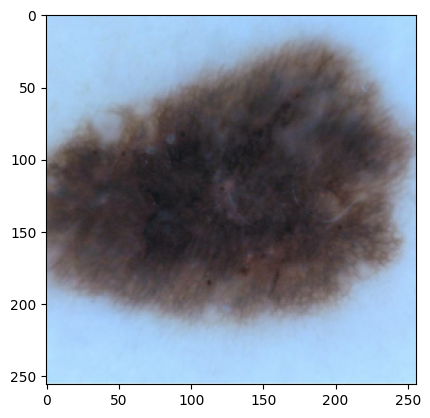

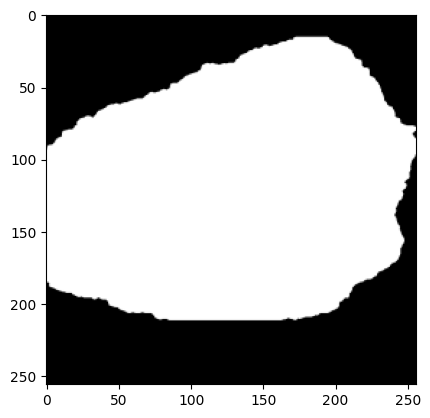

In [8]:
inp, re = load('/kaggle/input/cancer1/data/train/ISIC_0000000.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [9]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [10]:
#increases the diversity of the training dataset in data agumentation
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
    stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [11]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [12]:
@tf.function() #converts a Python function into a TensorFlow graph function for better performance
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
    # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

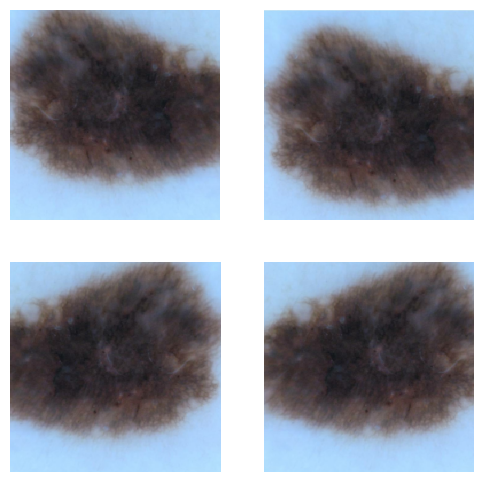

In [13]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [14]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [15]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [16]:
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset = tf.data.Dataset.list_files(PATH+'/val/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
#reducing the spatial dimensions by using convolutional layers with a stride greater than 2.
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02) #mean,std

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [22]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [23]:
def unet_generator(output_channels):
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    skips = []
    x = inputs
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4),
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                           strides=2,
                                           padding='same',
                                           activation='tanh') 

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = unet_generator(output_channels=3) 


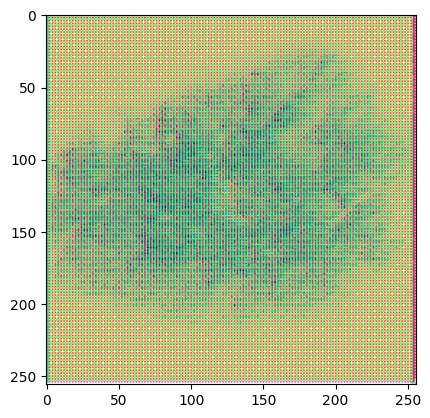

In [25]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [26]:
LAMBDA = 100

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [28]:
def unet_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) 

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

generator = unet_generator(OUTPUT_CHANNELS)
generator.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 128, 128,  │      3,072 │ input_layer_18[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 64, 64,    │    131,584 │ sequential_17[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 32, 32,    │    525,312 │ sequential_18[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 16, 16,    │  2,099,200 │ sequential_19[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 8, 8, 512) │  4,196,352 │ sequential_20[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 4, 4, 512) │  4,196,352 │ sequential_21[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 2, 2, 512) │  4,196,352 │ sequential_22[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 1, 1, 512) │  4,196,352 │ sequential_23[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_25       │ (None, 2, 2, 512) │  4,196,352 │ sequential_24[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 2, 2,      │          0 │ sequential_25[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_26       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 4, 4,      │          0 │ sequential_26[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_27       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 8, 8,      │          0 │ sequential_27[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_28       │ (None, 16, 16,    │  8,390,656 │ concatenate_9[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 16, 16,    │          0 │ sequential_28[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [29]:
discriminator = unet_discriminator()
discriminator.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_32       │ (None, 128, 128,  │      6,144 │ concatenate_14[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_33       │ (None, 64, 64,    │    131,584 │ sequential_32[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_34       │ (None, 32, 32,    │    525,312 │ sequential_33[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_34[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_20[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

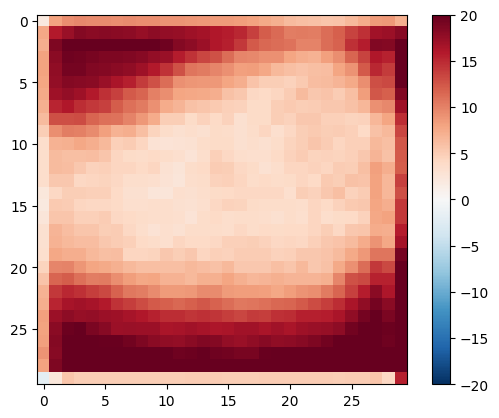

In [30]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


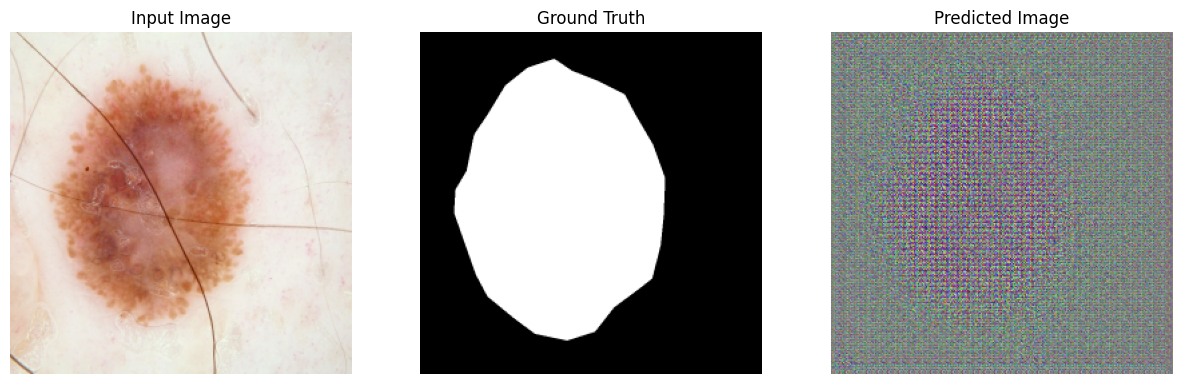

In [36]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [37]:
EPOCHS = 10

In [38]:
import datetime

log_dir = "/home/user/logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [39]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [40]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
          generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

    # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                    print()
            train_step(input_image, target, epoch)
            print()

    # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
        checkpoint.save(file_prefix = checkpoint_prefix)

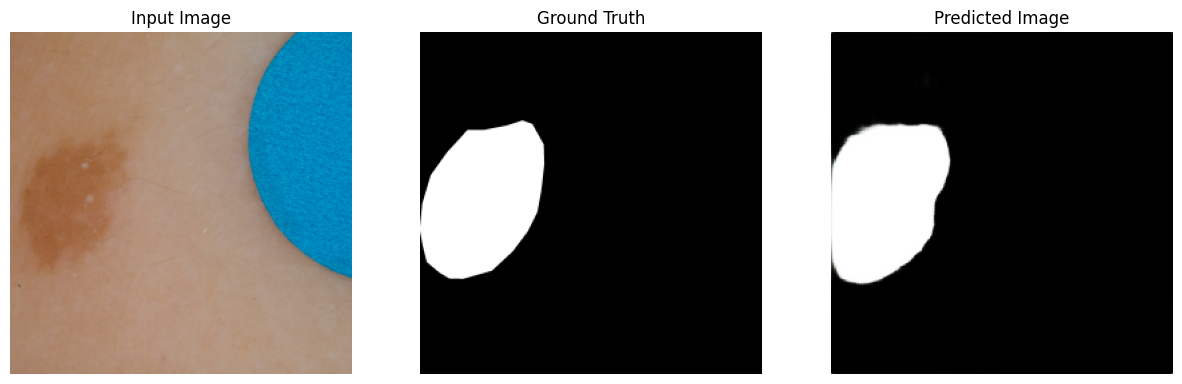

Epoch:  4
.

2024-05-07 07:34:06.166993: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_35_1/sequential_25_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

In [ ]:
model = fit(train_dataset, EPOCHS, test_dataset)
model

In [ ]:
model.summary()

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset:
    generate_images(generator, inp, tar)

In [ ]:
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr(gt_image, generated_image):
    psnr = tf.image.psnr(gt_image, generated_image, max_val=1.0)
    return psnr

def calculate_ssim(gt_image, generated_image):
    ssim = tf.image.ssim(gt_image, generated_image, max_val=1.0)
    return ssim

# Assuming you have a generator and a test dataset
for input_image, target in test_dataset:
    generated_image = generator(input_image, training=False)
    
    psnr = calculate_psnr(target, generated_image)
    ssim = calculate_ssim(target, generated_image)
    
    print("PSNR:", psnr.numpy())
    print("SSIM:", ssim.numpy())


In [ ]:
import tensorflow as tf
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr(gt_image, generated_image):
    psnr = tf.image.psnr(gt_image, generated_image, max_val=1.0)
    return psnr

def calculate_ssim(gt_image, generated_image):
    ssim = tf.image.ssim(gt_image, generated_image, max_val=1.0)
    return ssim

psnr_values = []
ssim_values = []

# Assuming you have a generator and a test dataset
for input_image, target in test_dataset:
    generated_image = generator(input_image, training=False)
    
    psnr = calculate_psnr(target, generated_image)
    ssim = calculate_ssim(target, generated_image)
    
    psnr_values.append(psnr.numpy())
    ssim_values.append(ssim.numpy())

# Convert lists to numpy arrays
psnr_values = np.array(psnr_values)
ssim_values = np.array(ssim_values)

# Compute average PSNR and SSIM
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

print("Average PSNR:", average_psnr)
print("Average SSIM:", average_ssim)


In [ ]:
import tensorflow as tf
from scipy.special import kl_div
import numpy as np

inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299), method=tf.image.ResizeMethod.BILINEAR)
    return tf.keras.applications.inception_v3.preprocess_input(images_resized)

def calculate_inception_score(images, batch_size=32):
    images_preprocessed = preprocess_images(images)
    probs = []
    for i in range(0, len(images_preprocessed), batch_size):
        batch = images_preprocessed[i:i+batch_size]
        batch_probs = inception_model.predict(batch)
        probs.append(batch_probs)
    probs = np.concatenate(probs, axis=0)
    p_y = np.mean(probs, axis=0)
    kl_divs = []
    for probs_i in probs:
        kl_divs.append(kl_div(p_y, probs_i))
    kl_divs = np.array(kl_divs)
    kl_divs = np.mean(kl_divs, axis=0)
    return np.exp(np.mean(kl_divs))

inception_score = calculate_inception_score(gen_output)
print("Inception Score:", inception_score)


In [ ]:
from sklearn.cluster import KMeans

num_samples, height, width, channels = gen_output.shape
flattened_gen_output = tf.reshape(gen_output, (num_samples * height * width, channels))

k = 5 

with tf.device('/CPU:0'):  
    flattened_gen_output_np = flattened_gen_output.numpy()

kmeans = KMeans(n_clusters=k)
kmeans.fit(flattened_gen_output)
cluster_centroids = kmeans.cluster_centers_

original_shape = (num_samples, height, width, channels)

cluster_centroids_image = tf.reshape(cluster_centroids, original_shape)

In [ ]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(flattened_gen_output)
cluster_centroids = kmeans.cluster_centers_

original_shape = (num_samples, height, width, channels)

cluster_centroids_image = tf.reshape(cluster_centroids, original_shape)
